In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

In [ ]:
!pip install catboost

In [ ]:
df = pd.read_csv('/content/diabetes_binary_5050split_health_indicators_BRFSS2015.csv')
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (70692, 22)


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0


In [ ]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

stats = pd.DataFrame({
    'Missing Values': df[numeric_cols].isnull().sum(),
    'Min': df[numeric_cols].min(),
    'Max': df[numeric_cols].max(),
    'Median': df[numeric_cols].median(),
    'Mean': df[numeric_cols].mean(),
    'Std Dev': df[numeric_cols].std()
})

# % of Missing Values
stats['Missing Values (%)'] = (df[numeric_cols].isnull().sum() / len(df) * 100).round(2)
stats['Missing Values'] = stats.apply(lambda x: f"{int(x['Missing Values'])} ({x['Missing Values (%)']}%)", axis=1)
stats.drop(columns=['Missing Values (%)'], inplace=True)
stats = stats[['Missing Values', 'Min', 'Max', 'Median', 'Mean', 'Std Dev']]

# Table
print("Table 1. Statistical Analysis of the Diabetes Prediction Dataset")
display(stats.style.set_table_attributes('style=\"border-collapse:collapse\"')
        .set_caption("Table 1. Statistical Analysis of the Diabetes Prediction Dataset")
        .set_table_styles([
            {'selector': 'caption', 'props': [('caption-side', 'top'), ('font-style', 'italic'), ('text-align', 'center'), ('font-size', '14px')]},
            {'selector': 'th', 'props': [('background-color', '##808080'), ('font-weight', 'bold'), ('text-align', 'center')]},
            {'selector': 'td', 'props': [('text-align', 'center')]}
        ]))


Table 1. Statistical Analysis of the Diabetes Prediction Dataset


,Missing Values,Min,Max,Median,Mean,Std Dev
Diabetes_binary,0 (0.0%),0.000000,1.000000,0.500000,0.500000,0.500004
HighBP,0 (0.0%),0.000000,1.000000,1.000000,0.563458,0.495960
HighChol,0 (0.0%),0.000000,1.000000,1.000000,0.525703,0.499342
CholCheck,0 (0.0%),0.000000,1.000000,1.000000,0.975259,0.155336
BMI,0 (0.0%),12.000000,98.000000,29.000000,29.856985,7.113954
Smoker,0 (0.0%),0.000000,1.000000,0.000000,0.475273,0.499392
Stroke,0 (0.0%),0.000000,1.000000,0.000000,0.062171,0.241468
HeartDiseaseorAttack,0 (0.0%),0.000000,1.000000,0.000000,0.147810,0.354914
PhysActivity,0 (0.0%),0.000000,1.000000,1.000000,0.703036,0.456924
Fruits,0 (0.0%),0.000000,1.000000,1.000000,0.611795,0.487345


In [ ]:
print("\nMissing values per column:")
df.fillna(df.mean(), inplace=True)


Missing values per column:


In [ ]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df[col] = np.where(df[col] < lower_bound, lower_bound,
              np.where(df[col] > upper_bound, upper_bound, df[col]))

print("After handling outliers:", df.shape)

After handling outliers: (70692, 22)


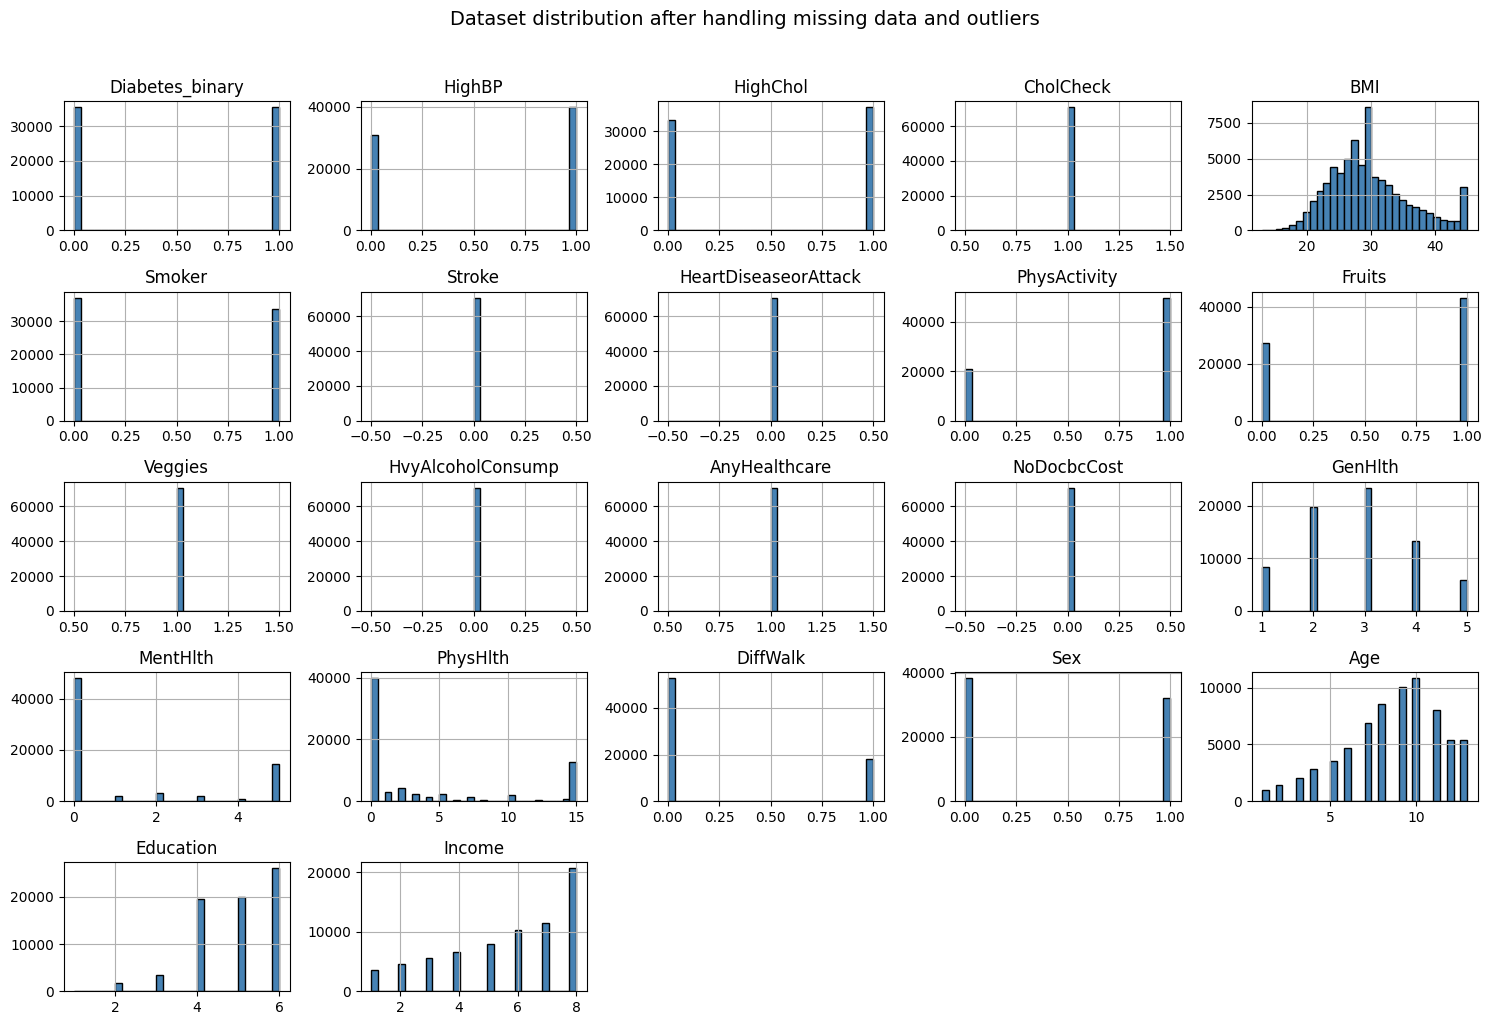

In [ ]:
df[numeric_cols].hist(figsize=(15, 10), bins=30, color='steelblue', edgecolor='black')
plt.suptitle('Dataset distribution after handling missing data and outliers', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
X = df.drop('Diabetes_binary', axis=1)
y = df['Diabetes_binary']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=300, solver='lbfgs', random_state=42),
    "Decision Tree": DecisionTreeClassifier(max_depth=6, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42),
    "K nearest neighbors (KNN)": KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    "AdaBoost": AdaBoostClassifier(n_estimators=50, random_state=42),
    "Extra Trees": ExtraTreesClassifier(n_estimators=50, n_jobs=-1, random_state=42)
}
print("5-Fold Cross-Validation Results:\n")
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{name}: {scores.mean():.4f} ± {scores.std():.4f}")

# Train and Eval
results = []

print("=" * 80)
print("Model Performance".center(80))
print("=" * 80)

for name, model in models.items():
    print(f"\n Training: {name}")
    print("-" * 80)

    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()

    y_pred = model.predict(X_test)

    # Evaluation metrics
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=0, output_dict=True)
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']
    cm = confusion_matrix(y_test, y_pred)

    # Save and Print results
    print(f"{name} Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.2f} | Recall: {recall:.2f} | F1-score: {f1:.2f}")
    print(f"Training Time: {end - start:.2f} seconds\n")

    results.append({
        "Algorithm": name,
        "Accuracy": f"{acc*100:.0f}%",
        "Precision": round(precision, 2),
        "Recall": round(recall, 2),
        "F1-score": round(f1, 2),
        "Training Time (s)": round(end - start, 2),
        "conf_matrix": cm
    })

summary_df = pd.DataFrame(results)

print("\n" + "=" * 80)
print("📋 OVERALL MODEL COMPARISON")
print("=" * 80)
print(summary_df.to_string(index=False))

5-Fold Cross-Validation Results:

Logistic Regression: 0.7458 ± 0.0023
Decision Tree: 0.7389 ± 0.0045
Random Forest: 0.7295 ± 0.0032
K nearest neighbors (KNN): 0.7074 ± 0.0042
AdaBoost: 0.7455 ± 0.0034
Extra Trees: 0.7175 ± 0.0046
                               Model Performance                                

 Training: Logistic Regression
--------------------------------------------------------------------------------
Logistic Regression Accuracy: 0.7426
Precision: 0.74 | Recall: 0.74 | F1-score: 0.74
Training Time: 0.14 seconds


 Training: Decision Tree
--------------------------------------------------------------------------------
Decision Tree Accuracy: 0.7364
Precision: 0.74 | Recall: 0.74 | F1-score: 0.74
Training Time: 0.11 seconds


 Training: Random Forest
--------------------------------------------------------------------------------
Random Forest Accuracy: 0.7254
Precision: 0.73 | Recall: 0.73 | F1-score: 0.73
Training Time: 2.60 seconds


 Training: K nearest neighbors

In [ ]:
print("Unique values and counts for all columns:")
for col in df.columns:
    print(f"\nColumn: {col}")
    display(df[col].value_counts())

Unique values and counts for all columns:

Column: Diabetes_binary


,count
Diabetes_binary,
0.0,35346
1.0,35346



Column: HighBP


,count
HighBP,
1.0,39832
0.0,30860



Column: HighChol


,count
HighChol,
1.0,37163
0.0,33529



Column: CholCheck


,count
CholCheck,
1.0,70692



Column: BMI


,count
BMI,
27.0,6327
26.0,4975
28.0,4583
24.0,4392
30.0,4344
29.0,4219
25.0,4031
31.0,3753
32.0,3481



Column: Smoker


,count
Smoker,
0.0,37094
1.0,33598



Column: Stroke


,count
Stroke,
0.0,70692



Column: HeartDiseaseorAttack


,count
HeartDiseaseorAttack,
0.0,70692



Column: PhysActivity


,count
PhysActivity,
1.0,49699
0.0,20993



Column: Fruits


,count
Fruits,
1.0,43249
0.0,27443



Column: Veggies


,count
Veggies,
1.0,70692



Column: HvyAlcoholConsump


,count
HvyAlcoholConsump,
0.0,70692



Column: AnyHealthcare


,count
AnyHealthcare,
1.0,70692



Column: NoDocbcCost


,count
NoDocbcCost,
0.0,70692



Column: GenHlth


,count
GenHlth,
3.0,23427
2.0,19872
4.0,13303
1.0,8282
5.0,5808



Column: MentHlth


,count
MentHlth,
0.0,48091
5.0,14335
2.0,3267
1.0,2051
3.0,1967
4.0,981



Column: PhysHlth


,count
PhysHlth,
0.0,39915
15.0,12537
2.0,4102
1.0,2853
3.0,2438
5.0,2332
10.0,1980
4.0,1376
7.0,1326



Column: DiffWalk


,count
DiffWalk,
0.0,52826
1.0,17866



Column: Sex


,count
Sex,
0.0,38386
1.0,32306



Column: Age


,count
Age,
10.0,10856
9.0,10112
8.0,8603
11.0,8044
7.0,6872
13.0,5426
12.0,5394
6.0,4648
5.0,3520



Column: Education


,count
Education,
6.0,26020
5.0,20030
4.0,19473
3.0,3447
2.0,1647
1.0,75



Column: Income


,count
Income,
8.0,20646
7.0,11425
6.0,10287
5.0,8010
4.0,6658
3.0,5557
2.0,4498
1.0,3611


In [ ]:
print("Unique values and counts in 'Diabetes_binary' column:")
display(df['Diabetes_binary'].value_counts())

Unique values and counts in 'Diabetes_binary' column:


,count
Diabetes_binary,
0.0,35346
1.0,35346


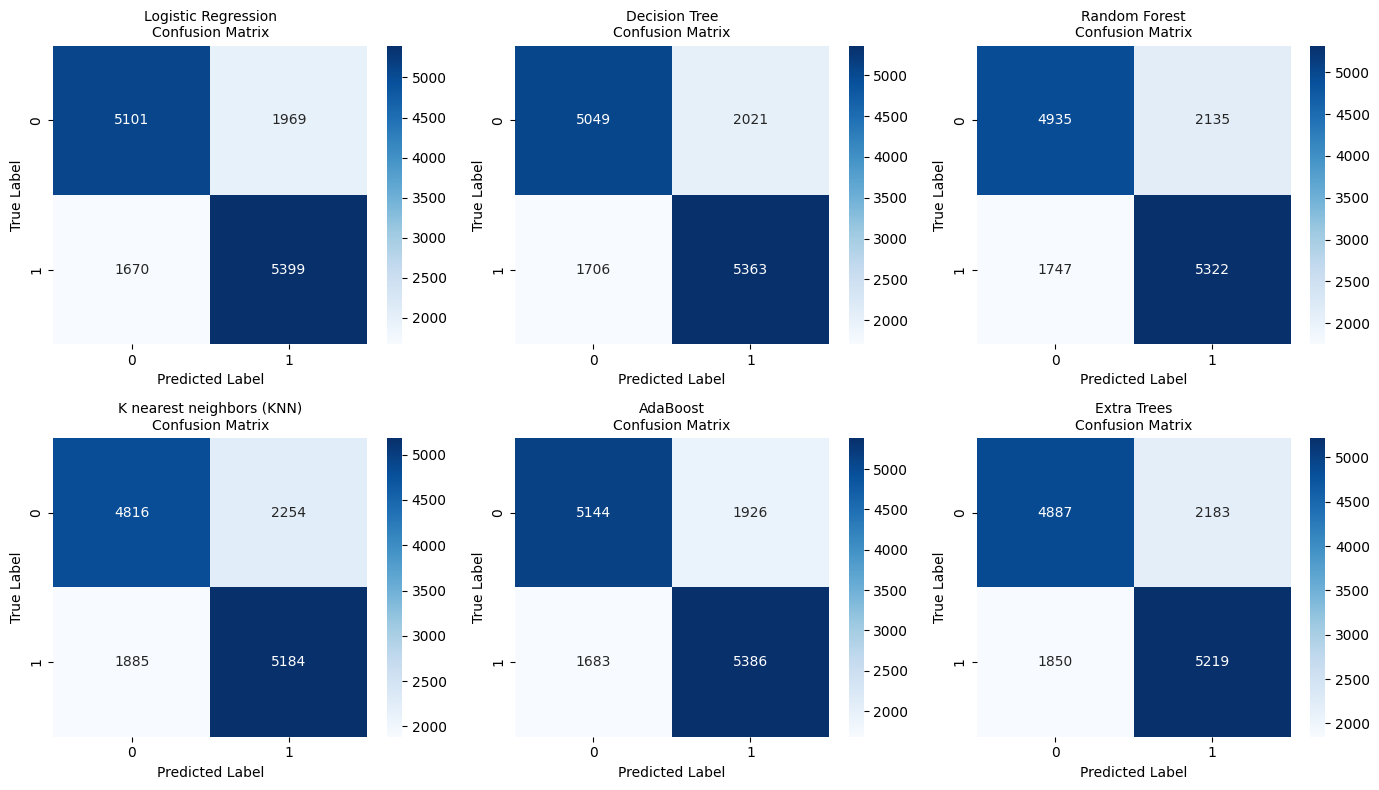

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.ravel()

for idx, result_dict in enumerate(results):
    cm = result_dict["conf_matrix"]
    name = result_dict["Algorithm"]

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], cbar=True)
    axes[idx].set_title(f"{name}\nConfusion Matrix", fontsize=10)
    axes[idx].set_xlabel("Predicted Label")
    axes[idx].set_ylabel("True Label")

for i in range(len(results), len(axes)):
    fig.delaxes(axes[i])


plt.tight_layout()
plt.show()